In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy import stats
from scipy.special import expit as logistic

based on https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")

%watermark -n -u -v -iv -w

Last updated: Wed Aug 24 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

pymc      : 4.1.3
scipy     : 1.8.1
matplotlib: 3.5.2
numpy     : 1.22.4
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
pandas    : 1.4.3
arviz     : 0.12.1

Watermark: 2.3.1



#### 14.1 simulated cafes

In [3]:
a = 3.5 ## intercept = mean morning wait time
b = -1.0 ## slope = diff btw morning and afternoon
sA = 1 ## sd intercept
sB = 0.5 ## sd slope
r = -0.7 ## correlation slope and intercept

In [4]:
Mu = [a, b]
svec = [sA, sB]
Rho = np.array([[1,r],[r,1]]) ## correlation matrix
Sigma = np.diag(svec) @ Rho @ np.diag(svec) ## var-covar matrix

In [5]:
nCafes = 20
intercepts_slopes = np.random.multivariate_normal(Mu, Sigma, nCafes)

In [6]:
x0 = np.random.multivariate_normal(Mu, Sigma, 20000)
x1 = stats.multivariate_normal.pdf(x0,Mu,Sigma)

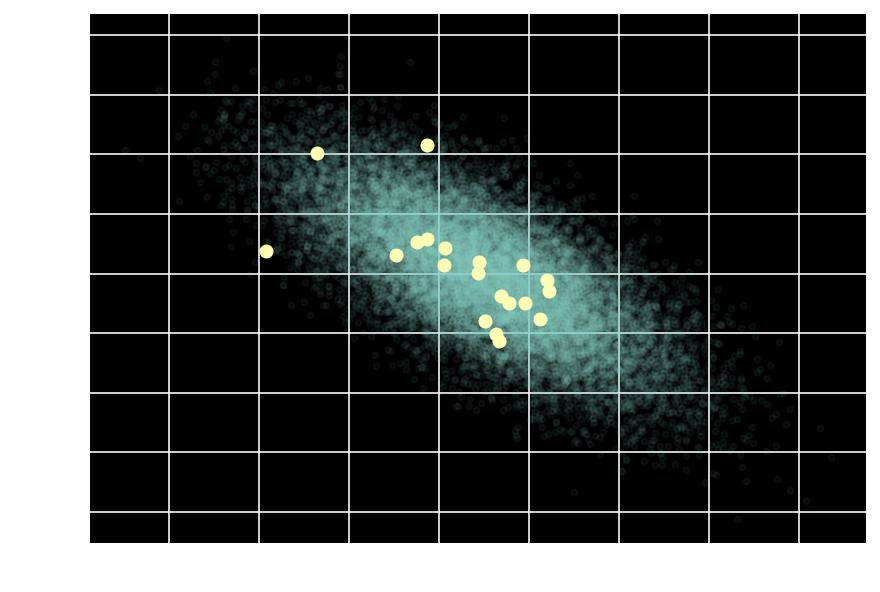

In [17]:
_, ax = plt.subplots()
ax.scatter(x0[:,0], x0[:,1], marker='.', alpha=0.05) #0.05*logistic(-10*x1))
ax.scatter(intercepts_slopes[:,0],intercepts_slopes[:,1])


In [18]:
nVisits = 10
afternoon = np.tile([0,1], nVisits * nCafes // 2)
cafeId = np.repeat(np.arange(nCafes), nVisits)
muWait = intercepts_slopes[cafeId,0] + intercepts_slopes[cafeId,1] * afternoon
sWait = 0.5

In [19]:
obsWait = np.random.normal(muWait, sWait, nVisits * nCafes)
d = pd.DataFrame({'cafe': cafeId, 'afternoon': afternoon, 'wait': obsWait})
d.head()

cafe  afternoon      wait
0     0          0  3.420332
1     0          1  2.699930
2     0          0  3.065045
3     0          1  2.900627
4     0          0  4.070025

<AxesSubplot:>

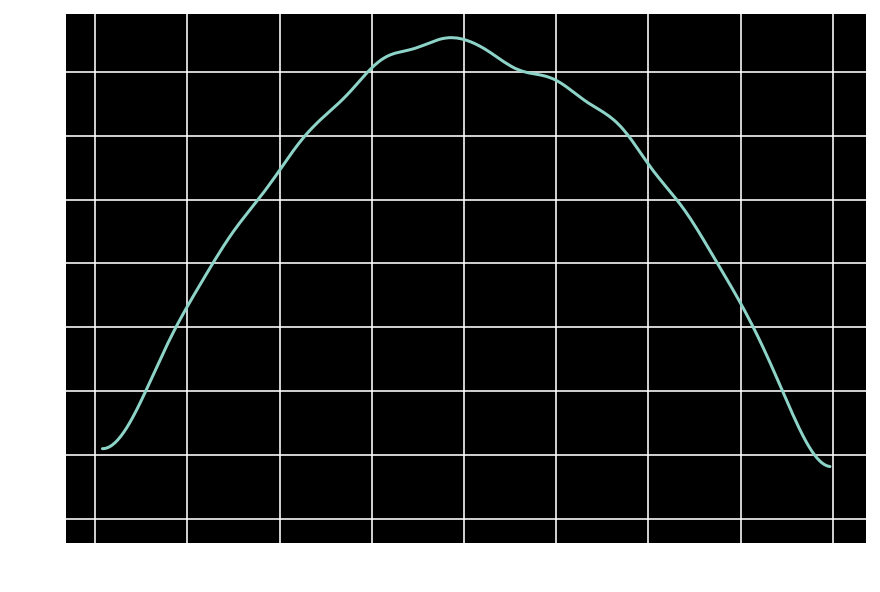

In [20]:
## LKJ distribution is used to generate correlation coefficients
##   when n=2, generates a single coefficient (for a 2x2 correlation matrix)
x = pm.LKJCorr.dist(n=2, eta=2, size=10000)
az.plot_kde(x.eval())

In [21]:
## when n > 2, generates coeffiecients for an n x n correlation matrix
x = pm.LKJCorr.dist(n=4, eta=2, size=3)
print(x.eval())

[[-0.94561431  0.25186538  0.11659903 -0.27959192  0.05086108  0.36379679]
 [ 0.20920331  0.49406956  0.40081386  0.01182507  0.47887032  0.15263826]
 [-0.15223446  0.46787368  0.10394988  0.12116541 -0.65596734  0.40033207]]


In [22]:
with pm.Model() as m1:
    ##pm.LKJCholeskyCov produces chol decomp which can be fed directly to pm.MvNormal
    ##  (pm.LKJCorr only generates rhos, and then we'd have to do matrix algebra)
    ##   note .dist()
    chol, _, _ = pm.LKJCholeskyCov("chol", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0))
    mu_ab = pm.Normal("mu_ab", [5.0, -1.0], [2.0, 0.5], shape=2)
    ## note shape
    ab = pm.MvNormal("ab", mu=mu_ab, chol=chol, shape=(nCafes,2))
    cafeId = pm.MutableData("cafe_id", d['cafe'])
    afternoon = pm.MutableData("afternoon", d['afternoon'])
    ## likelihood
    muWait = pm.Deterministic("mu_wait", ab[cafeId,0] + ab[cafeId,1] * afternoon)
    sWait = pm.Exponential("sigma_wait", 1)
    obsWait = pm.Normal("wait", muWait, sWait, observed=d['wait'])
    trace1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, mu_ab, ab, sigma_wait]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [23]:
trace1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

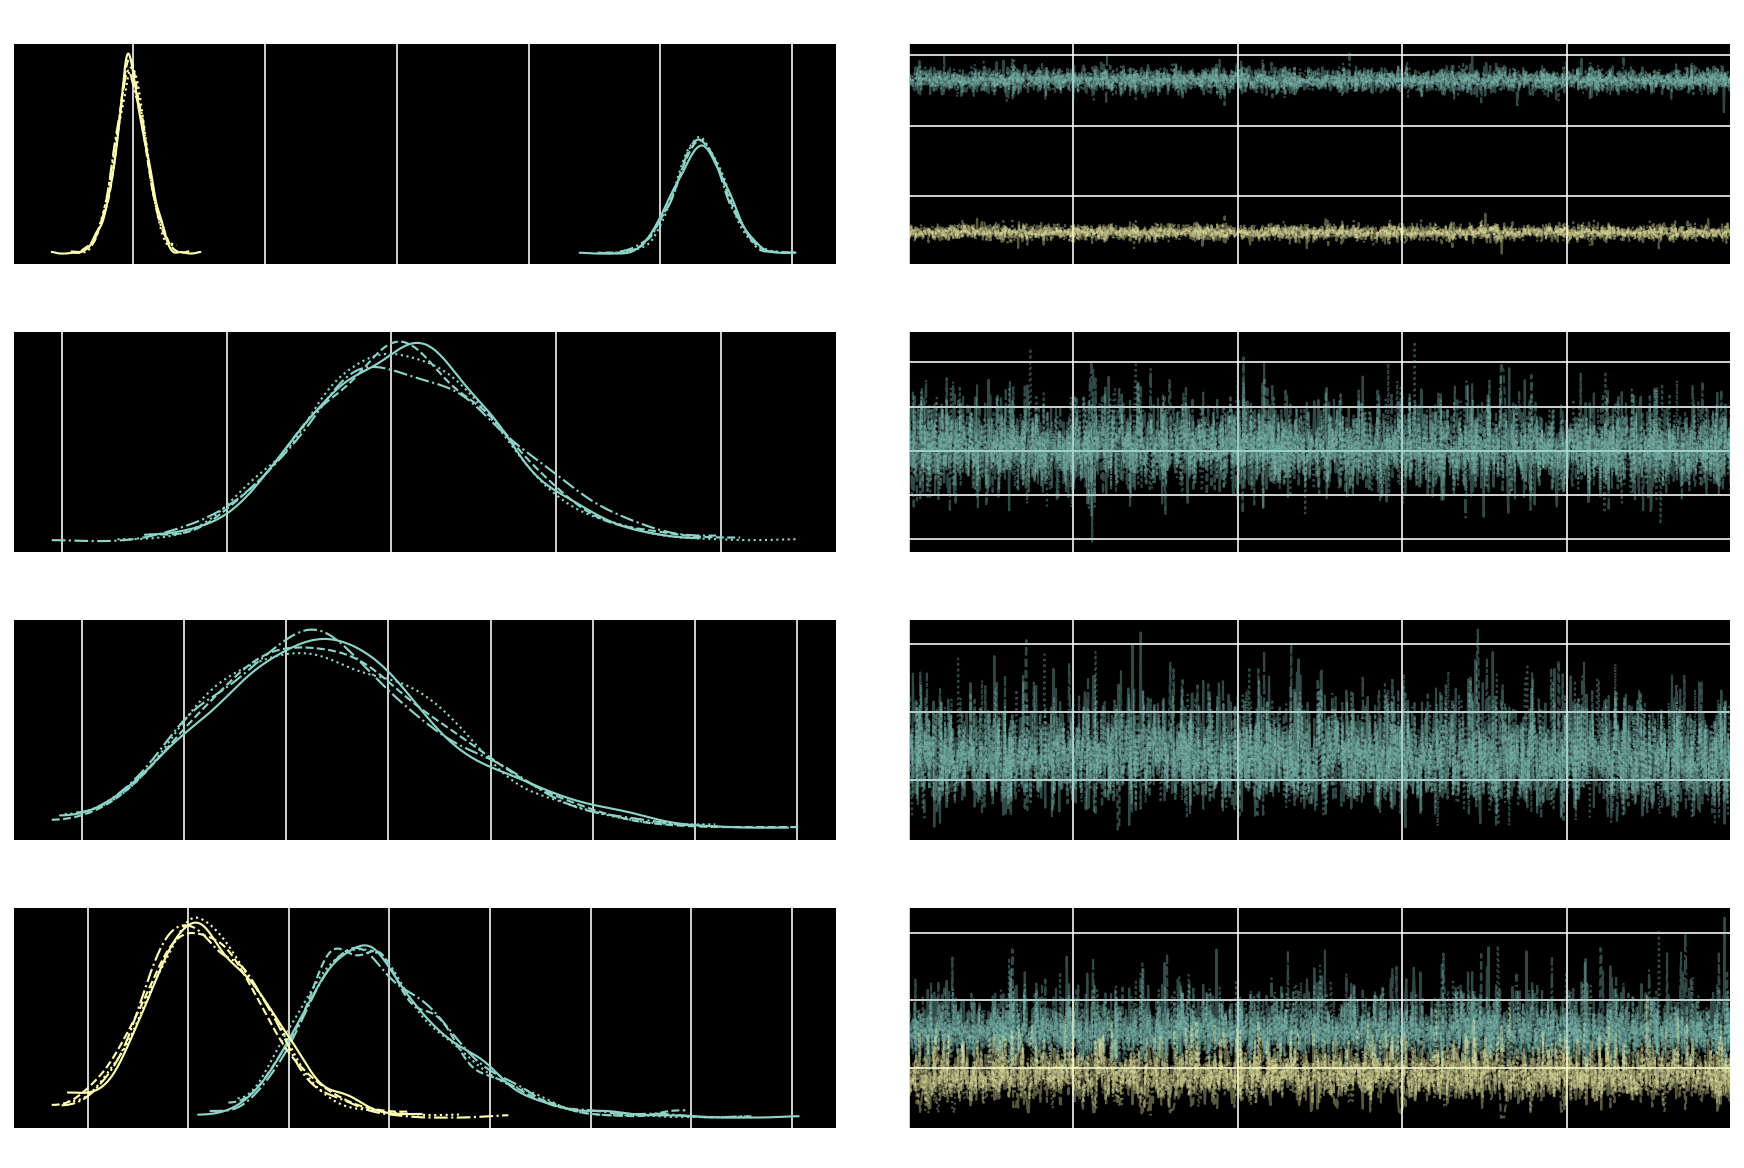

In [24]:
az.plot_trace(trace1, var_names=['mu_ab','sigma_wait','chol_corr','chol_stds'],
coords={'chol_corr_dim_0':1, 'chol_corr_dim_1':0});

In [25]:
az.summary(trace1,var_names=['~ab','~mu_wait'])

/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_ab[0]         3.301  0.189   2.959    3.656      0.003    0.002    4775.0   
mu_ab[1]        -1.021  0.119  -1.228   -0.777      0.002    0.001    4035.0   
chol[0]          0.787  0.146   0.545    1.064      0.002    0.002    5001.0   
chol[1]         -0.142  0.116  -0.358    0.071      0.002    0.001    3648.0   
chol[2]          0.403  0.108   0.200    0.600      0.002    0.002    1924.0   
sigma_wait       0.505  0.029   0.450    0.557      0.000    0.000    4263.0   
chol_corr[0, 0]  1.000  0.000   1.000    1.000      0.000    0.000    4000.0   
chol_corr[0, 1] -0.312  0.226  -0.710    0.121      0.004    0.003    4152.0   
chol_corr[1, 0] -0.312  0.226  -0.710    0.121      0.004    0.003    4152.0   
chol_corr[1, 1]  1.000  0.000   1.000    1.000      0.000    0.000    3867.0   
chol_stds[0]     0.787  0.146   0.545    1.064      0.002    0.002    5001.0   
chol_stds[1]     0.440  0.118   0.216    0.658      0.003    0.002    1834.0   

                 ess_tail  r_hat  
mu_ab[0]           3185.0    1.0  
mu_ab[1]           3577.0    1.0  
chol[0]            3081.0    1.0  
chol[1]            3264.0    1.0  
chol[2]            1384.0    1.0  
sigma_wait         2918.0    1.0  
chol_corr[0, 0]    4000.0    NaN  
chol_corr[0, 1]    3323.0    1.0  
chol_corr[1, 0]    3323.0    1.0  
chol_corr[1, 1]    3936.0    1.0  
chol_stds[0]       3081.0    1.0  
chol_stds[1]       1432.0    1.0

In [26]:
az.summary(trace1, var_names=['mu_ab','sigma_wait','chol_corr','chol_stds'],
coords={'chol_corr_dim_0':1, 'chol_corr_dim_1':0})

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_ab[0]      3.301  0.189   2.959    3.656      0.003    0.002    4775.0   
mu_ab[1]     -1.021  0.119  -1.228   -0.777      0.002    0.001    4035.0   
sigma_wait    0.505  0.029   0.450    0.557      0.000    0.000    4263.0   
chol_corr    -0.312  0.226  -0.710    0.121      0.004    0.003    4152.0   
chol_stds[0]  0.787  0.146   0.545    1.064      0.002    0.002    5001.0   
chol_stds[1]  0.440  0.118   0.216    0.658      0.003    0.002    1834.0   

              ess_tail  r_hat  
mu_ab[0]        3185.0    1.0  
mu_ab[1]        3577.0    1.0  
sigma_wait      2918.0    1.0  
chol_corr       3323.0    1.0  
chol_stds[0]    3081.0    1.0  
chol_stds[1]    1432.0    1.0

<AxesSubplot:>

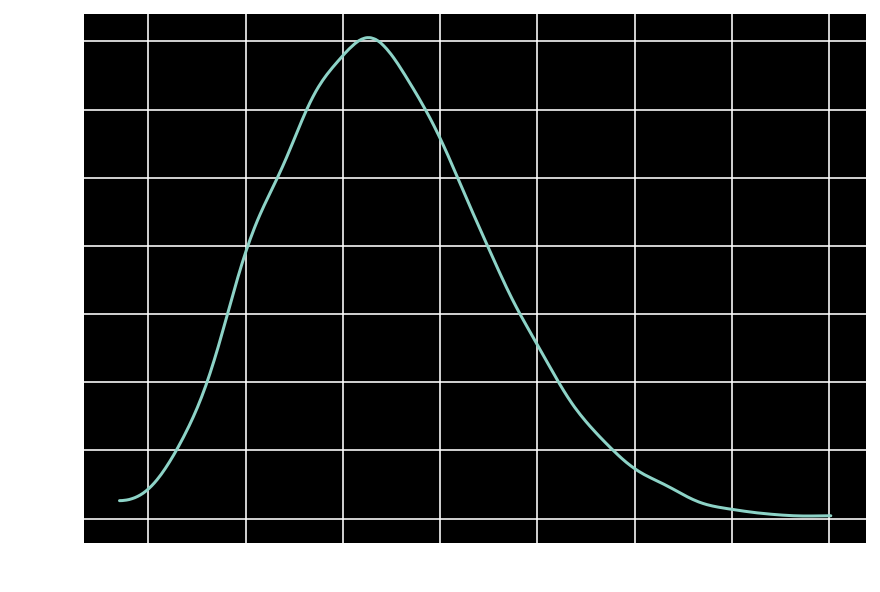

In [27]:
post = trace1.posterior
az.plot_kde(post['chol_corr'][:,:,1,0].values)

In [28]:
obsMeans = d.groupby(['afternoon','cafe']).mean()
obsMeans

wait
afternoon cafe          
0         0     3.533047
          1     2.939268
          2     3.553339
          3     1.540247
          4     3.336206
          5     3.727117
          6     1.581653
          7     3.067552
          8     3.632552
          9     2.966635
          10    2.828407
          11    3.553629
          12    3.007799
          13    2.967595
          14    4.364292
          15    4.101640
          16    4.441053
          17    4.347754
          18    2.728646
          19    3.546181
1         0     2.467559
          1     3.005117
          2     1.702115
          3     0.015079
          4     2.215461
          5     2.614026
          6     1.644229
          7     2.283518
          8     3.063641
          9     2.695454
          10    1.881349
          11    2.688361
          12    1.875628
          13    2.066994
          14    2.962899
          15    2.755022
          16    3.280807
          17    2.464940
          18    1.775773
          19    1.945184

In [29]:
estMeans = post['ab'].mean(['chain','draw'])
estMeans

<xarray.DataArray 'ab' (ab_dim_0: 20, ab_dim_1: 2)>
array([[ 3.51691323, -1.05509911],
       [ 3.13073834, -0.34642941],
       [ 3.40565387, -1.54081496],
       [ 1.53929723, -1.31062123],
       [ 3.32007123, -1.08223746],
       [ 3.69095609, -1.08123941],
       [ 1.83988894, -0.34134392],
       [ 3.11465221, -0.87042282],
       [ 3.68983319, -0.73978315],
       [ 3.10948382, -0.56350876],
       [ 2.85877105, -0.97199232],
       [ 3.5696041 , -0.93224202],
       [ 3.00276981, -1.08921729],
       [ 2.99631593, -0.93435718],
       [ 4.2560304 , -1.2668106 ],
       [ 4.01671785, -1.23165708],
       [ 4.36824927, -1.12094243],
       [ 4.15473435, -1.55829223],
       [ 2.76268834, -0.9689731 ],
       [ 3.43665531, -1.37737155]])
Coordinates:
  * ab_dim_0  (ab_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * ab_dim_1  (ab_dim_1) int64 0 1

In [30]:
obsA = obsMeans.loc[0,'wait'].values  # morning
obsB = obsMeans.loc[1,'wait'].values - obsA  # afternoon - morning
estA = estMeans[:,0].values # intercepts
estB = estMeans[:,1].values # slopes
obsMorning = obsA
obsAfternoon = obsA + obsB
estMorning = estA
estAfternoon = estA + estB

estMu = post['mu_ab'].mean(['chain','draw']).values
estSvec = post['chol_stds'].mean(['chain','draw']).values
estRho = post['chol_corr'].mean(['chain','draw']).values
estSigma = np.diag(estSvec) @ estRho @ np.diag(estSvec)
x0 = np.random.multivariate_normal(estMu, estSigma, 20000)

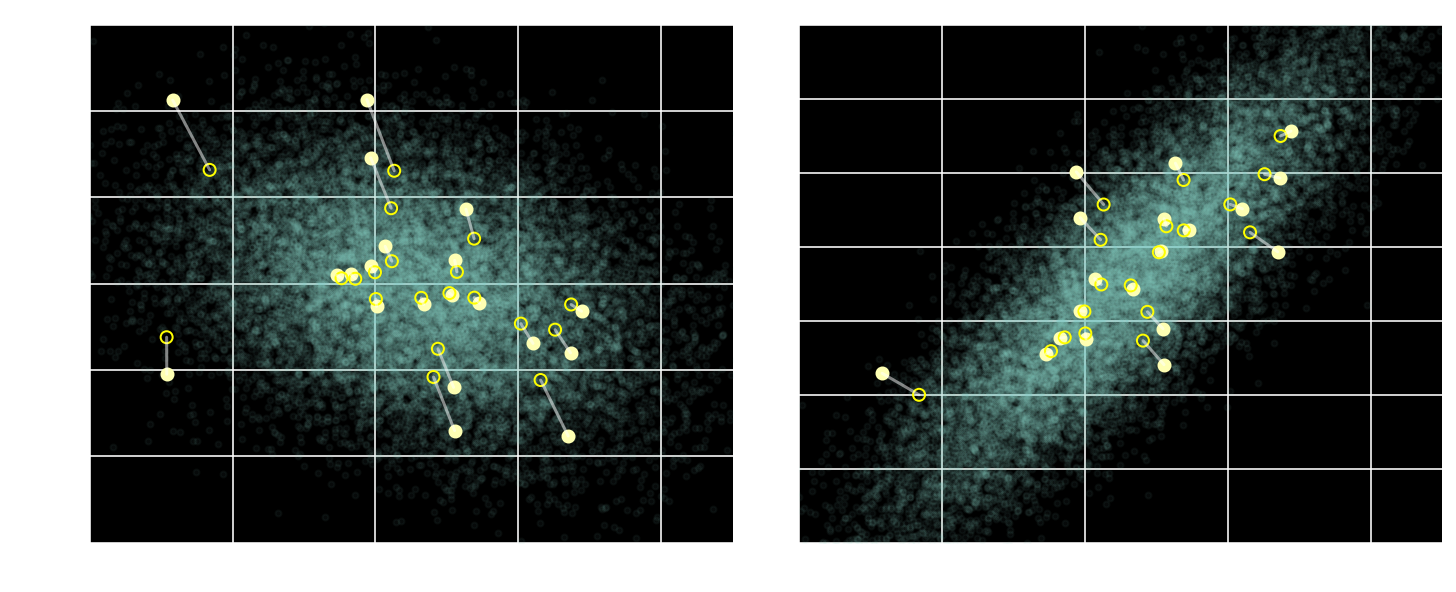

In [31]:
_, (ax,ax2) = plt.subplots(1,2,figsize=[10,4])
ax.set_xlim(1.0,5.5)
ax.set_ylim(-2.5,0.5)
ax.scatter(x0[:,0], x0[:,1], marker='.', alpha=0.05);
ax.scatter(obsA, obsB)
ax.scatter(estA, estB, facecolors="none", edgecolors="yellow", lw=1, alpha=1.0)
ax.plot([obsA, estA], [obsB, estB], "w-", alpha=0.5);

ax2.set_xlim(1,5.5)
ax2.set_ylim(0.5,4.0)
ax2.scatter(x0[:,0], x0[:,0] + x0[:,1], marker='.', alpha=0.05);
ax2.scatter(obsMorning, obsAfternoon)
ax2.scatter(estMorning, estAfternoon, facecolors="none", edgecolors="yellow", lw=1, alpha=1.0)
ax2.plot([obsMorning, estMorning], [obsAfternoon, estAfternoon], "w-", alpha=0.5);


#### 14.2 full example

In [40]:
d = pd.read_csv("Data/chimpanzees.csv", sep=';')
d["actor"] -= 1
d["block"] -= 1
d["treatment"] = d["prosoc_left"] + 2*d["condition"]
d.head()

actor  recipient  condition  block  trial  prosoc_left  chose_prosoc  \
0      0        NaN          0      0      2            0             1   
1      0        NaN          0      0      4            0             0   
2      0        NaN          0      0      6            1             0   
3      0        NaN          0      0      8            0             1   
4      0        NaN          0      0     10            1             1   

   pulled_left  treatment  
0            0          0  
1            1          0  
2            0          1  
3            0          0  
4            1          1

In [41]:
actor_idx, actors = pd.factorize(d["actor"])
treatment_idx, treatments = pd.factorize(d["treatment"])
block_idx, blocks = pd.factorize(d["block"])

$L \sim Binomial(1, p)$ : pull left with binomial probability p  

$ logit(p) = g_{tid} + a_{actor,tid} + b_{block,tid}$  
log-odds = treatment effect + separate actor effect for each treatment (interaction) + block-treatment interaction

$(a_{j,1..4}) \sim MVNormal((0..0), S_{actor})$  
the actor effects come from a shared distribution in which the 4 treatment responses are correlated

$(b_{j,1..4}) \sim MVNormal((0..0), S_{block})$  
likewise for the block effects

In [57]:
with pm.Model() as m2:
    g = pm.Normal("g", 0, 1, shape=len(treatments))
    sdA = pm.Exponential.dist(1.0)
    sdB = pm.Exponential.dist(1.0)
    cholA, _, _ = pm.LKJCholeskyCov("actor_treat", n=len(treatments), eta=2, sd_dist=sdA)
    cholB, _, _ = pm.LKJCholeskyCov("block_treat", n=len(treatments), eta=2, sd_dist=sdB)
    a = pm.MvNormal("a", mu=0, chol=cholA, shape=(len(actors), len(treatments)))
    b = pm.MvNormal("b", mu=0, chol=cholB, shape=(len(blocks), len(treatments)))
    t_id = pm.MutableData("t_id", treatment_idx)
    a_id = pm.MutableData("a_id", actor_idx)
    b_id = pm.MutableData("b_id", block_idx)
    p = pm.Deterministic("p", pm.math.invlogit(g[t_id] + a[a_id,t_id] + b[b_id,t_id]))
    L = pm.Binomial("pulled_left", 1, p, observed=d['pulled_left'])
    trace2 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, actor_treat, block_treat, a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
There were 177 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6611, but should be close to 0.8. Try to increase the number of tuning steps.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.


In [47]:
## same but with noncentered parameters
with pm.Model() as m3:
    g = pm.Normal("g", 0, 1, shape=len(treatments))
    sdA = pm.Exponential.dist(1.0)
    sdB = pm.Exponential.dist(1.0)
    cholA, _, _ = pm.LKJCholeskyCov("actor_treat", n=len(treatments), eta=2, sd_dist=sdA)
    cholB, _, _ = pm.LKJCholeskyCov("block_treat", n=len(treatments), eta=2, sd_dist=sdB)
    ## note this parameter matrix is treatments x actors
    ##   (or else you have to transpose matrices below)
    zA = pm.Normal("zA", 0, 1, shape=(len(treatments), len(actors)))
    ## cholesky decomp x zA = mvnormal parameter matrix, shape treatments x actors
    a = pm.Deterministic("a", pm.math.dot(cholA, zA)) ## a[treatment, actor]
    ## instead of: a = pm.MvNormal("a", mu=0, chol=cholA, shape=(len(actors), len(treatments)))
    zB = pm.Normal("zB", 0, 1, shape=(len(treatments), len(blocks))) ## zB[treatment, block]
    b = pm.Deterministic("b", pm.math.dot(cholB, zB)) ## b[treatment, block]
    t_id = pm.MutableData("t_id", treatment_idx)
    a_id = pm.MutableData("a_id", actor_idx)
    b_id = pm.MutableData("b_id", block_idx)
    p = pm.Deterministic("p", pm.math.invlogit(g[t_id] + a[t_id,a_id] + b[t_id,b_id]))
    #instead of : p = pm.Deterministic("p", pm.math.invlogit(g[t_id] + a[a_id,t_id] + b[b_id,t_id]))
    L = pm.Binomial("pulled_left", 1, p, observed=d['pulled_left'])
    trace3 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, actor_treat, block_treat, zA, zB]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
The acceptance probability does not match the target. It is 0.6725, but should be close to 0.8. Try to increase the number of tuning steps.


In [48]:
trace3

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [56]:
az.summary(trace3, var_names=['g','actor_treat_stds','block_treat_stds'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
g[0]                 0.244  0.493  -0.580    1.225      0.016    0.012   
g[1]                 0.631  0.397  -0.110    1.377      0.011    0.009   
g[2]                 0.051  0.581  -1.049    1.052      0.049    0.035   
g[3]                 0.672  0.536  -0.267    1.730      0.020    0.014   
actor_treat_stds[0]  1.368  0.479   0.628    2.212      0.018    0.013   
actor_treat_stds[1]  0.953  0.460   0.323    1.917      0.042    0.031   
actor_treat_stds[2]  1.817  0.526   0.929    2.746      0.015    0.010   
actor_treat_stds[3]  1.558  0.602   0.632    2.642      0.024    0.017   
block_treat_stds[0]  0.422  0.316   0.000    0.970      0.008    0.006   
block_treat_stds[1]  0.450  0.349   0.010    1.042      0.019    0.014   
block_treat_stds[2]  0.295  0.268   0.007    0.778      0.015    0.010   
block_treat_stds[3]  0.479  0.363   0.018    1.130      0.016    0.012   

                     ess_bulk  ess_tail  r_hat  
g[0]                    893.0    1618.0   1.01  
g[1]                   1230.0    1764.0   1.00  
g[2]                    141.0    2195.0   1.02  
g[3]                    704.0    1606.0   1.01  
actor_treat_stds[0]     682.0     959.0   1.01  
actor_treat_stds[1]     202.0     325.0   1.03  
actor_treat_stds[2]    1285.0    2000.0   1.00  
actor_treat_stds[3]     358.0      61.0   1.01  
block_treat_stds[0]    1369.0    1395.0   1.02  
block_treat_stds[1]     220.0     140.0   1.02  
block_treat_stds[2]      72.0      18.0   1.04  
block_treat_stds[3]     408.0     769.0   1.01

In [105]:
d_pred = {'a_id': np.repeat(range(7),4), 't_id':np.tile(range(4),7), 'b_id':np.repeat(3,7*4)}
with m3:
    pm.set_data(d_pred)
    post_pred = pm.sample_posterior_predictive(trace3, var_names=['p','pulled_left'])

In [125]:
## by actor first, then by treatment
obs_meanL = d.groupby(['actor','treatment']).mean()['pulled_left'].values
## same order given in d_pred above
pred_meanL = post_pred.posterior_predictive['p'].mean(['chain','draw']).values
pred_meanL
## could reshape to make indexing easier

array([0.38927421, 0.56979546, 0.2688854 , 0.52494997, 0.94922577,
       0.92035528, 0.96521537, 0.96284703, 0.3394903 , 0.60097447,
       0.18082795, 0.36995477, 0.36620948, 0.54703094, 0.13702625,
       0.42906776, 0.39102238, 0.59051103, 0.26238931, 0.4964246 ,
       0.74693434, 0.66512231, 0.5243603 , 0.63476765, 0.80821234,
       0.82977368, 0.90718603, 0.93774907])

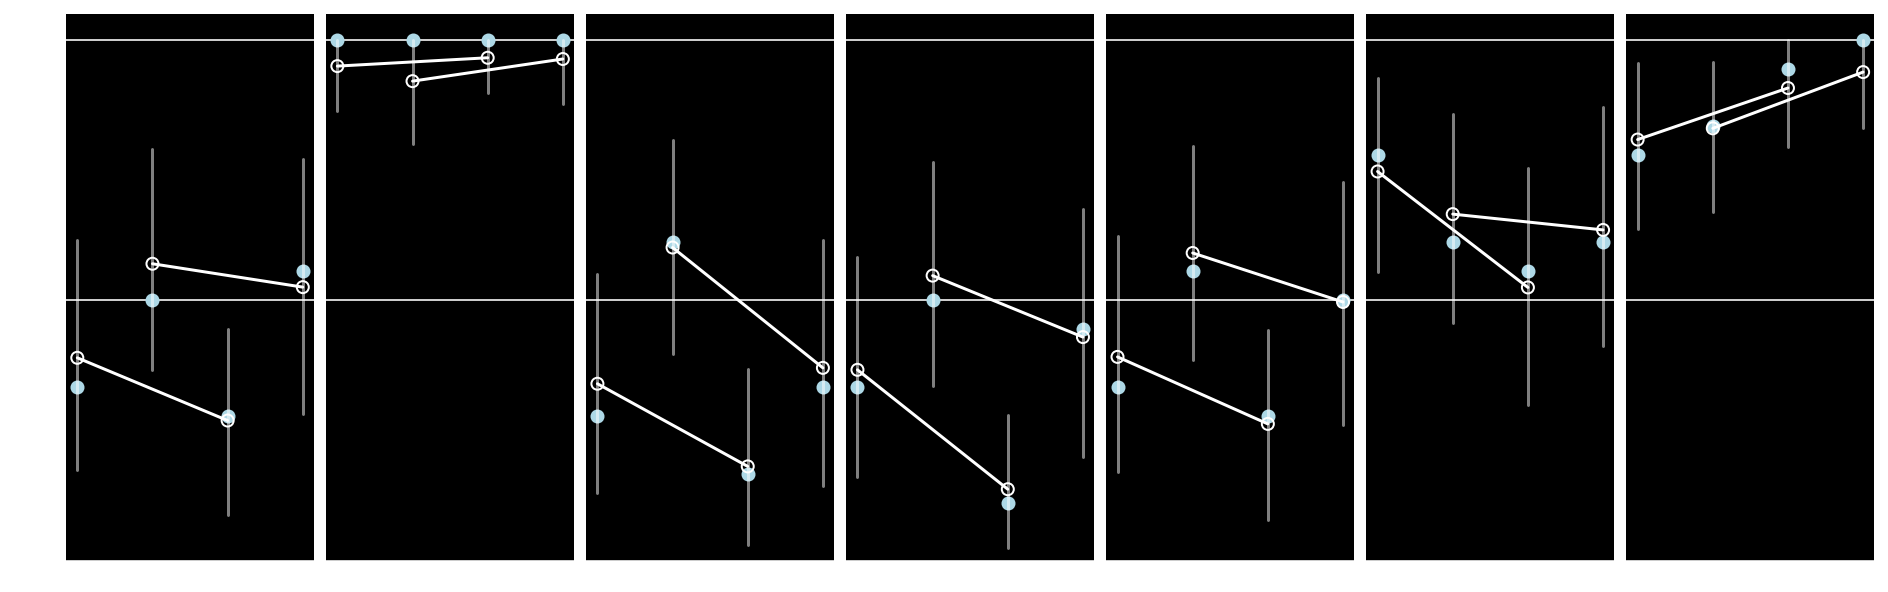

In [170]:
_, ax = plt.subplots(1, 7, sharey=True, figsize=[13,4])
for i in range(7):
    ax[i].set_xticks([]); ax[i].set_ylim(0,1.05); ax[i].set_yticks([0,0.5,1])
    ax[i].scatter(np.arange(4), obs_meanL[i*4:i*4+4], color='lightblue')
    #ax[i].plot([0,2], [obs_meanL[i*4], obs_meanL[i*4+2]])
    #ax[i].plot([1,3], [obs_meanL[i*4+1], obs_meanL[i*4+3]])
    ax[i].scatter(np.arange(4), pred_meanL[i*4:i*4+4], color="none", edgecolor="w")
    ax[i].plot([0,2], [pred_meanL[i*4], pred_meanL[i*4+2]], color="w")
    ax[i].plot([1,3], [pred_meanL[i*4+1], pred_meanL[i*4+3]], color="w")
    #az.plot_hdi([0,2], post_pred.posterior_predictive['p'][:,:,i*4:i*4+3:2], ax=ax[i])
    #az.plot_hdi([1,3], post_pred.posterior_predictive['p'][:,:,i*4+1:i*4+4:2], ax=ax[i])
    for j in range (4):
        ax[i].plot([j,j], az.hdi(post_pred.posterior_predictive)['p'][i*4+j], color='w', alpha=0.5)

#### 14.4 social relations model

In [172]:
d = pd.read_csv("Data/KosterLeckie.csv", sep=',')
d

hidA  hidB  did  giftsAB  giftsBA  offset  drel1  drel2  drel3  drel4  \
0       1     2    1        0        4   0.000      0      0      1      0   
1       1     3    2        6       31  -0.003      0      1      0      0   
2       1     4    3        2        5  -0.019      0      1      0      0   
3       1     5    4        4        2   0.000      0      1      0      0   
4       1     6    5        8        2  -0.003      1      0      0      0   
..    ...   ...  ...      ...      ...     ...    ...    ...    ...    ...   
295    22    24  296        0        1   0.000      0      0      1      0   
296    22    25  297        2        0  -0.637      0      0      0      1   
297    23    24  298        2        0  -0.092      0      0      0      0   
298    23    25  299        4        0  -0.818      0      0      1      0   
299    24    25  300        2        0  -0.637      0      0      0      0   

     dlndist   dass  d0125  
0     -2.790  0.000      0  
1     -2.817  0.044      0  
2     -1.886  0.025      0  
3     -1.892  0.011      0  
4     -3.499  0.022      0  
..       ...    ...    ...  
295   -2.442  0.000      0  
296   -1.747  0.026      0  
297   -1.798  0.000      0  
298   -1.848  0.031      0  
299   -1.723  0.042      0  

[300 rows x 13 columns]

In [199]:
d['hidA'] -= 1
d['hidB'] -= 1
d['did'] -= 1
nHouse = 25
nDyad = len(d['did'].unique())

each household has an overall giving rate and overall receiving rate  
each dyad has two rates, $a \to b$ and $b \gets a$

$(0, s_g)$ and $(0, s_r)$ describe the distributions of giving and receiving rates  
do houses that give more also receive more? $r_{gr}$ is the correlation btw g's and r's  
so $(g, r) \sim mvn((0), (s_g, s_r, r_{gr}))$

$(0, s_d)$ describes the distribution of dyad-specific rates (both d_ab and d_ba)  
is giving reciprocal? $r_d$ is the correlation bewteen a->b's and b->a's  
so $(d_{ab}, d_{ba}) \sim mvn((0), (s_d, s_d, r_d))$

then  
- $\log(rate_{ij}) = \alpha + g_i + r_j + d_{ij}$  
- $gifts_{ij} \sim poisson(rate_{ij})$  
- $\log(rate_{ji}) = \alpha + g_j + r_i + d_{ji}$  
- $gifts_{ji} \sim poisson(rate_{ji})$

In [202]:
with pm.Model() as m7:
    a = pm.Normal("a", 0, 1)
    chol_gr, _, _ = pm.LKJCholeskyCov("chol_gr", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0))
    ## no way to set sd(d_ab) = sd(d_ba) ? could do it manually
    chol_dabba, _, _ = pm.LKJCholeskyCov("chol_dabba", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0))
    z_gr = pm.Normal("z_gr", 0, 1, shape=(2, nHouse))
    #gr = pm.MvNormal("gr", mu=0, chol=chol_gr, shape=(nHouse, 2))
    gr = pm.Deterministic("gr", pm.math.dot(chol_gr, z_gr))
    z_dabba = pm.Normal("z_dabba", 0, 1, shape=(2, nDyad))
    #dabba = pm.MvNormal("dabba", mu=0, chol=chol_dabba, shape=(nDyad, 2))
    dabba = pm.Deterministic("dabba", pm.math.dot(chol_dabba, z_dabba))
    hidA = pm.MutableData("hidA", d['hidA'])
    hidB = pm.MutableData("hidB", d['hidB'])
    did = pm.MutableData("did", d['did'])
    rateAB = pm.Deterministic("rateAB", pm.math.exp(a + gr[0, hidA] + gr[1, hidB] + dabba[0, did]))
    rateBA = pm.Deterministic("rateBA", pm.math.exp(a + gr[0, hidB] + gr[1, hidA] + dabba[1, did]))
    giftsAB = pm.Poisson("giftsAB", rateAB, observed=d['giftsAB'])
    giftsBA = pm.Poisson("giftsBA", rateBA, observed=d['giftsBA'])
    trace7 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, chol_gr, chol_dabba, z_gr, z_dabba]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.


In [203]:
trace7

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [205]:
## bivariate dist of general giving and receiving rates
az.summary(trace7, var_names=['chol_gr_corr', 'chol_gr_stds'])

/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
chol_gr_corr[0, 0]  1.000  0.000   1.000    1.000      0.000    0.000   
chol_gr_corr[0, 1] -0.523  0.207  -0.879   -0.121      0.005    0.004   
chol_gr_corr[1, 0] -0.523  0.207  -0.879   -0.121      0.005    0.004   
chol_gr_corr[1, 1]  1.000  0.000   1.000    1.000      0.000    0.000   
chol_gr_stds[0]     0.832  0.139   0.585    1.100      0.004    0.003   
chol_gr_stds[1]     0.406  0.089   0.239    0.570      0.003    0.002   

                    ess_bulk  ess_tail  r_hat  
chol_gr_corr[0, 0]    4000.0    4000.0    NaN  
chol_gr_corr[0, 1]    1299.0    1657.0    1.0  
chol_gr_corr[1, 0]    1299.0    1657.0    1.0  
chol_gr_corr[1, 1]    4108.0    4000.0    1.0  
chol_gr_stds[0]       1272.0    1939.0    1.0  
chol_gr_stds[1]       1162.0    1548.0    1.0

In [207]:
## bivariate dist of dyad rates d(a->b) and d(b->a)
az.summary(trace7, var_names=['chol_dabba_corr', 'chol_dabba_stds'])

/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
chol_dabba_corr[0, 0]  1.000  0.000   1.000    1.000      0.000    0.000   
chol_dabba_corr[0, 1]  0.940  0.027   0.888    0.985      0.001    0.001   
chol_dabba_corr[1, 0]  0.940  0.027   0.888    0.985      0.001    0.001   
chol_dabba_corr[1, 1]  1.000  0.000   1.000    1.000      0.000    0.000   
chol_dabba_stds[0]     1.086  0.068   0.961    1.214      0.002    0.001   
chol_dabba_stds[1]     1.147  0.068   1.019    1.271      0.002    0.001   

                       ess_bulk  ess_tail  r_hat  
chol_dabba_corr[0, 0]    4000.0    4000.0    NaN  
chol_dabba_corr[0, 1]     782.0     918.0   1.01  
chol_dabba_corr[1, 0]     782.0     918.0   1.01  
chol_dabba_corr[1, 1]    3705.0    3066.0   1.00  
chol_dabba_stds[0]       1366.0    2242.0   1.00  
chol_dabba_stds[1]       1434.0    2217.0   1.00

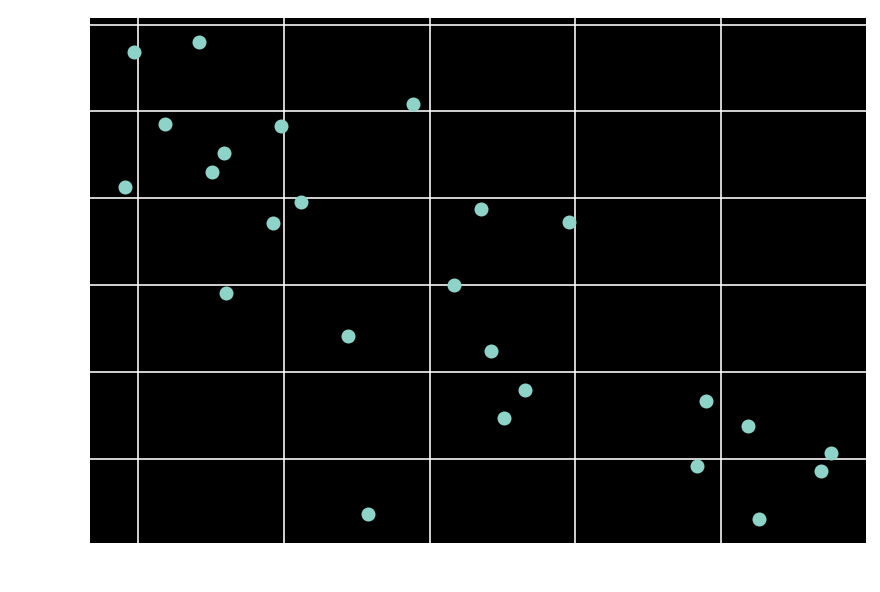

In [227]:
## effect of general giving and receiving (on log-odds scale)
plt.scatter((trace7.posterior['gr'].mean(['chain','draw'])[0,:]), 
            (trace7.posterior['gr'].mean(['chain','draw'])[1,:]));

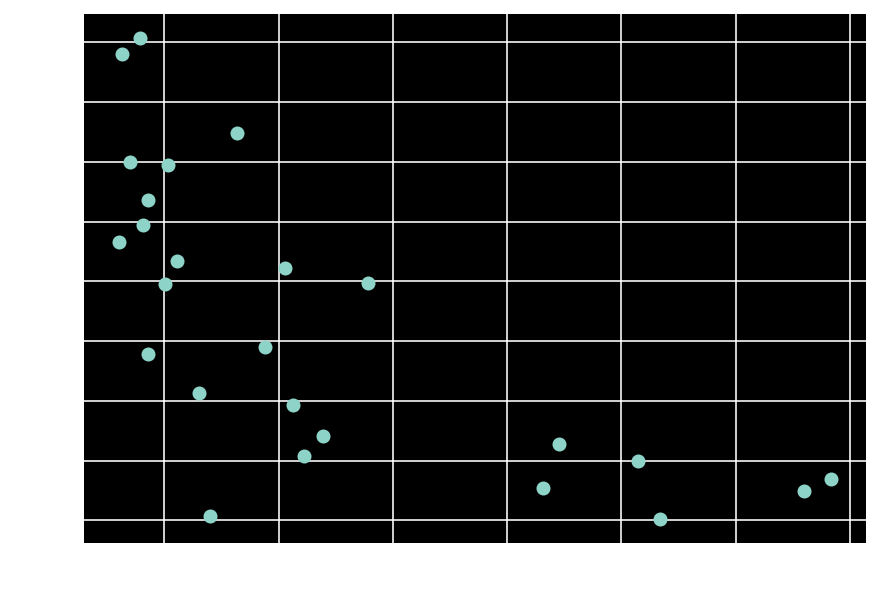

In [233]:
## general giving and receiving rate on outcome scale
## ignoring effect of reciprocity (which is assumed to have mean 0)
post7means = trace7.posterior.mean(['chain','draw'])
plt.scatter(np.exp(post7means['a'] + post7means['gr'][0,:]), 
            np.exp(post7means['a'] + post7means['gr'][1,:]));

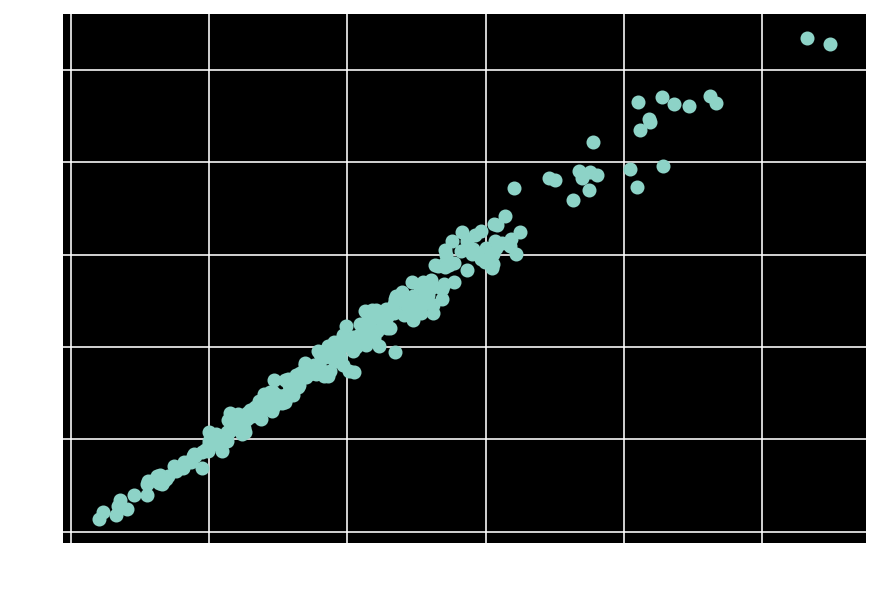

In [244]:
plt.scatter(post7means['dabba'][0,:], post7means['dabba'][1,:])

#### 14.3 instrumental variables

In [280]:
## simulate effect of education (E) on wages (W)
n = 500
## set true effect to 0
bEW_true = 0.0
## unobserved confound U
U_sim = np.random.normal(0, 1, n)
## quarter of birth Q influences education
##  if it's not affected by the unobs confound(s)
##  and doesn't directly influence W, then it can
##  be used as a natural experiment modulating E
Q_sim = np.random.randint(1, 5, n)
E_sim = np.random.normal(U_sim + Q_sim)
W_sim = np.random.normal(U_sim + bEW_true * E_sim)
dsim = pd.DataFrame({'W': stats.zscore(W_sim), 'E': stats.zscore(E_sim), 'Q': stats.zscore(Q_sim)})
## causality:
##  Q -> E -> W,  Q -> E <- U -> W


In [281]:
## simple regression of W on E
with pm.Model() as m4:
    aW = pm.Normal("aW", 0, 0.2)
    bEW = pm.Normal("bEW", 0, 0.5)
    mu = pm.Deterministic("mu", aW + bEW * dsim['E'])
    s = pm.Exponential("s", 1)
    W = pm.Normal("W", mu, s, observed=dsim['W'])
    trace4= pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, bEW, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [283]:
## bEW in this model reflects the confound U
az.summary(trace4, var_names=['~mu'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
aW   0.000  0.039  -0.077    0.071      0.001    0.001    5198.0    3108.0   
bEW  0.423  0.041   0.341    0.497      0.001    0.000    5590.0    3472.0   
s    0.907  0.030   0.851    0.961      0.000    0.000    5883.0    2848.0   

     r_hat  
aW     1.0  
bEW    1.0  
s      1.0

In [284]:
## naively including Q as a predictor
with pm.Model() as m5:
    aW = pm.Normal("aW", 0, 0.2)
    bEW = pm.Normal("bEW", 0, 0.5)
    bQW = pm.Normal("bQW", 0, 0.5)
    mu = pm.Deterministic("mu", aW + bEW * dsim['E'] + bQW * dsim['Q'])
    s = pm.Exponential("s", 1)
    W = pm.Normal("W", mu, s, observed=dsim['W'])
    trace5= pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, bEW, bQW, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [285]:
## this model amplifies the bias on bEW because of the non-causal path
##  Q -> E <- U -> W
## (E is a collider and bQW picks up U)
az.summary(trace5, var_names=['~mu'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
aW   0.000  0.038  -0.071    0.069      0.001    0.001    3857.0    3316.0   
bEW  0.664  0.049   0.568    0.750      0.001    0.001    2978.0    3143.0   
bQW -0.381  0.049  -0.474   -0.289      0.001    0.001    2873.0    3245.0   
s    0.857  0.027   0.807    0.908      0.000    0.000    3426.0    2622.0   

     r_hat  
aW     1.0  
bEW    1.0  
bQW    1.0  
s      1.0

In [376]:
## correctly using instrumental variable
with pm.Model() as m6:
    ## priors for slopes and intercepts
    aW = pm.Normal("aW", 0, 0.2)
    aE = pm.Normal("aE", 0, 0.2)    
    bEW = pm.Normal("bEW", 0, 0.5)
    bQE = pm.Normal("bQE", 0, 0.5)
    ## E -> expected W
    muW = aW + bEW * dsim['E']
    ## Q -> expected E
    muE = aE + bQE * dsim['Q']
    ## observed W and E depend on E and Q + error covariance that captures U
    chol, _, _ = pm.LKJCholeskyCov("chol", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0))
    WE = pm.MvNormal("WE", mu=pm.math.stack([muW,muE],axis=1), chol=chol, observed=dsim[['W','E']])
    ##                                           note axis=1
    trace6 = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [377]:
az.summary(trace6)

/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
aW               0.000  0.044  -0.086    0.080      0.001    0.001    4640.0   
aE              -0.000  0.034  -0.065    0.063      0.001    0.001    4439.0   
bEW              0.059  0.069  -0.066    0.195      0.002    0.001    1895.0   
bQE              0.630  0.035   0.567    0.698      0.001    0.000    3181.0   
chol[0]          0.981  0.040   0.910    1.060      0.001    0.001    2210.0   
chol[1]          0.374  0.046   0.284    0.459      0.001    0.001    1939.0   
chol[2]          0.680  0.028   0.628    0.734      0.001    0.000    2272.0   
chol_corr[0, 0]  1.000  0.000   1.000    1.000      0.000    0.000    4000.0   
chol_corr[0, 1]  0.481  0.054   0.376    0.578      0.001    0.001    1795.0   
chol_corr[1, 0]  0.481  0.054   0.376    0.578      0.001    0.001    1795.0   
chol_corr[1, 1]  1.000  0.000   1.000    1.000      0.000    0.000    3607.0   
chol_stds[0]     0.981  0.040   0.910    1.060      0.001    0.001    2210.0   
chol_stds[1]     0.777  0.025   0.733    0.826      0.000    0.000    4199.0   

                 ess_tail  r_hat  
aW                 3099.0    1.0  
aE                 2840.0    1.0  
bEW                2119.0    1.0  
bQE                2818.0    1.0  
chol[0]            2674.0    1.0  
chol[1]            2593.0    1.0  
chol[2]            2355.0    1.0  
chol_corr[0, 0]    4000.0    NaN  
chol_corr[0, 1]    2338.0    1.0  
chol_corr[1, 0]    2338.0    1.0  
chol_corr[1, 1]    3432.0    1.0  
chol_stds[0]       2674.0    1.0  
chol_stds[1]       3380.0    1.0

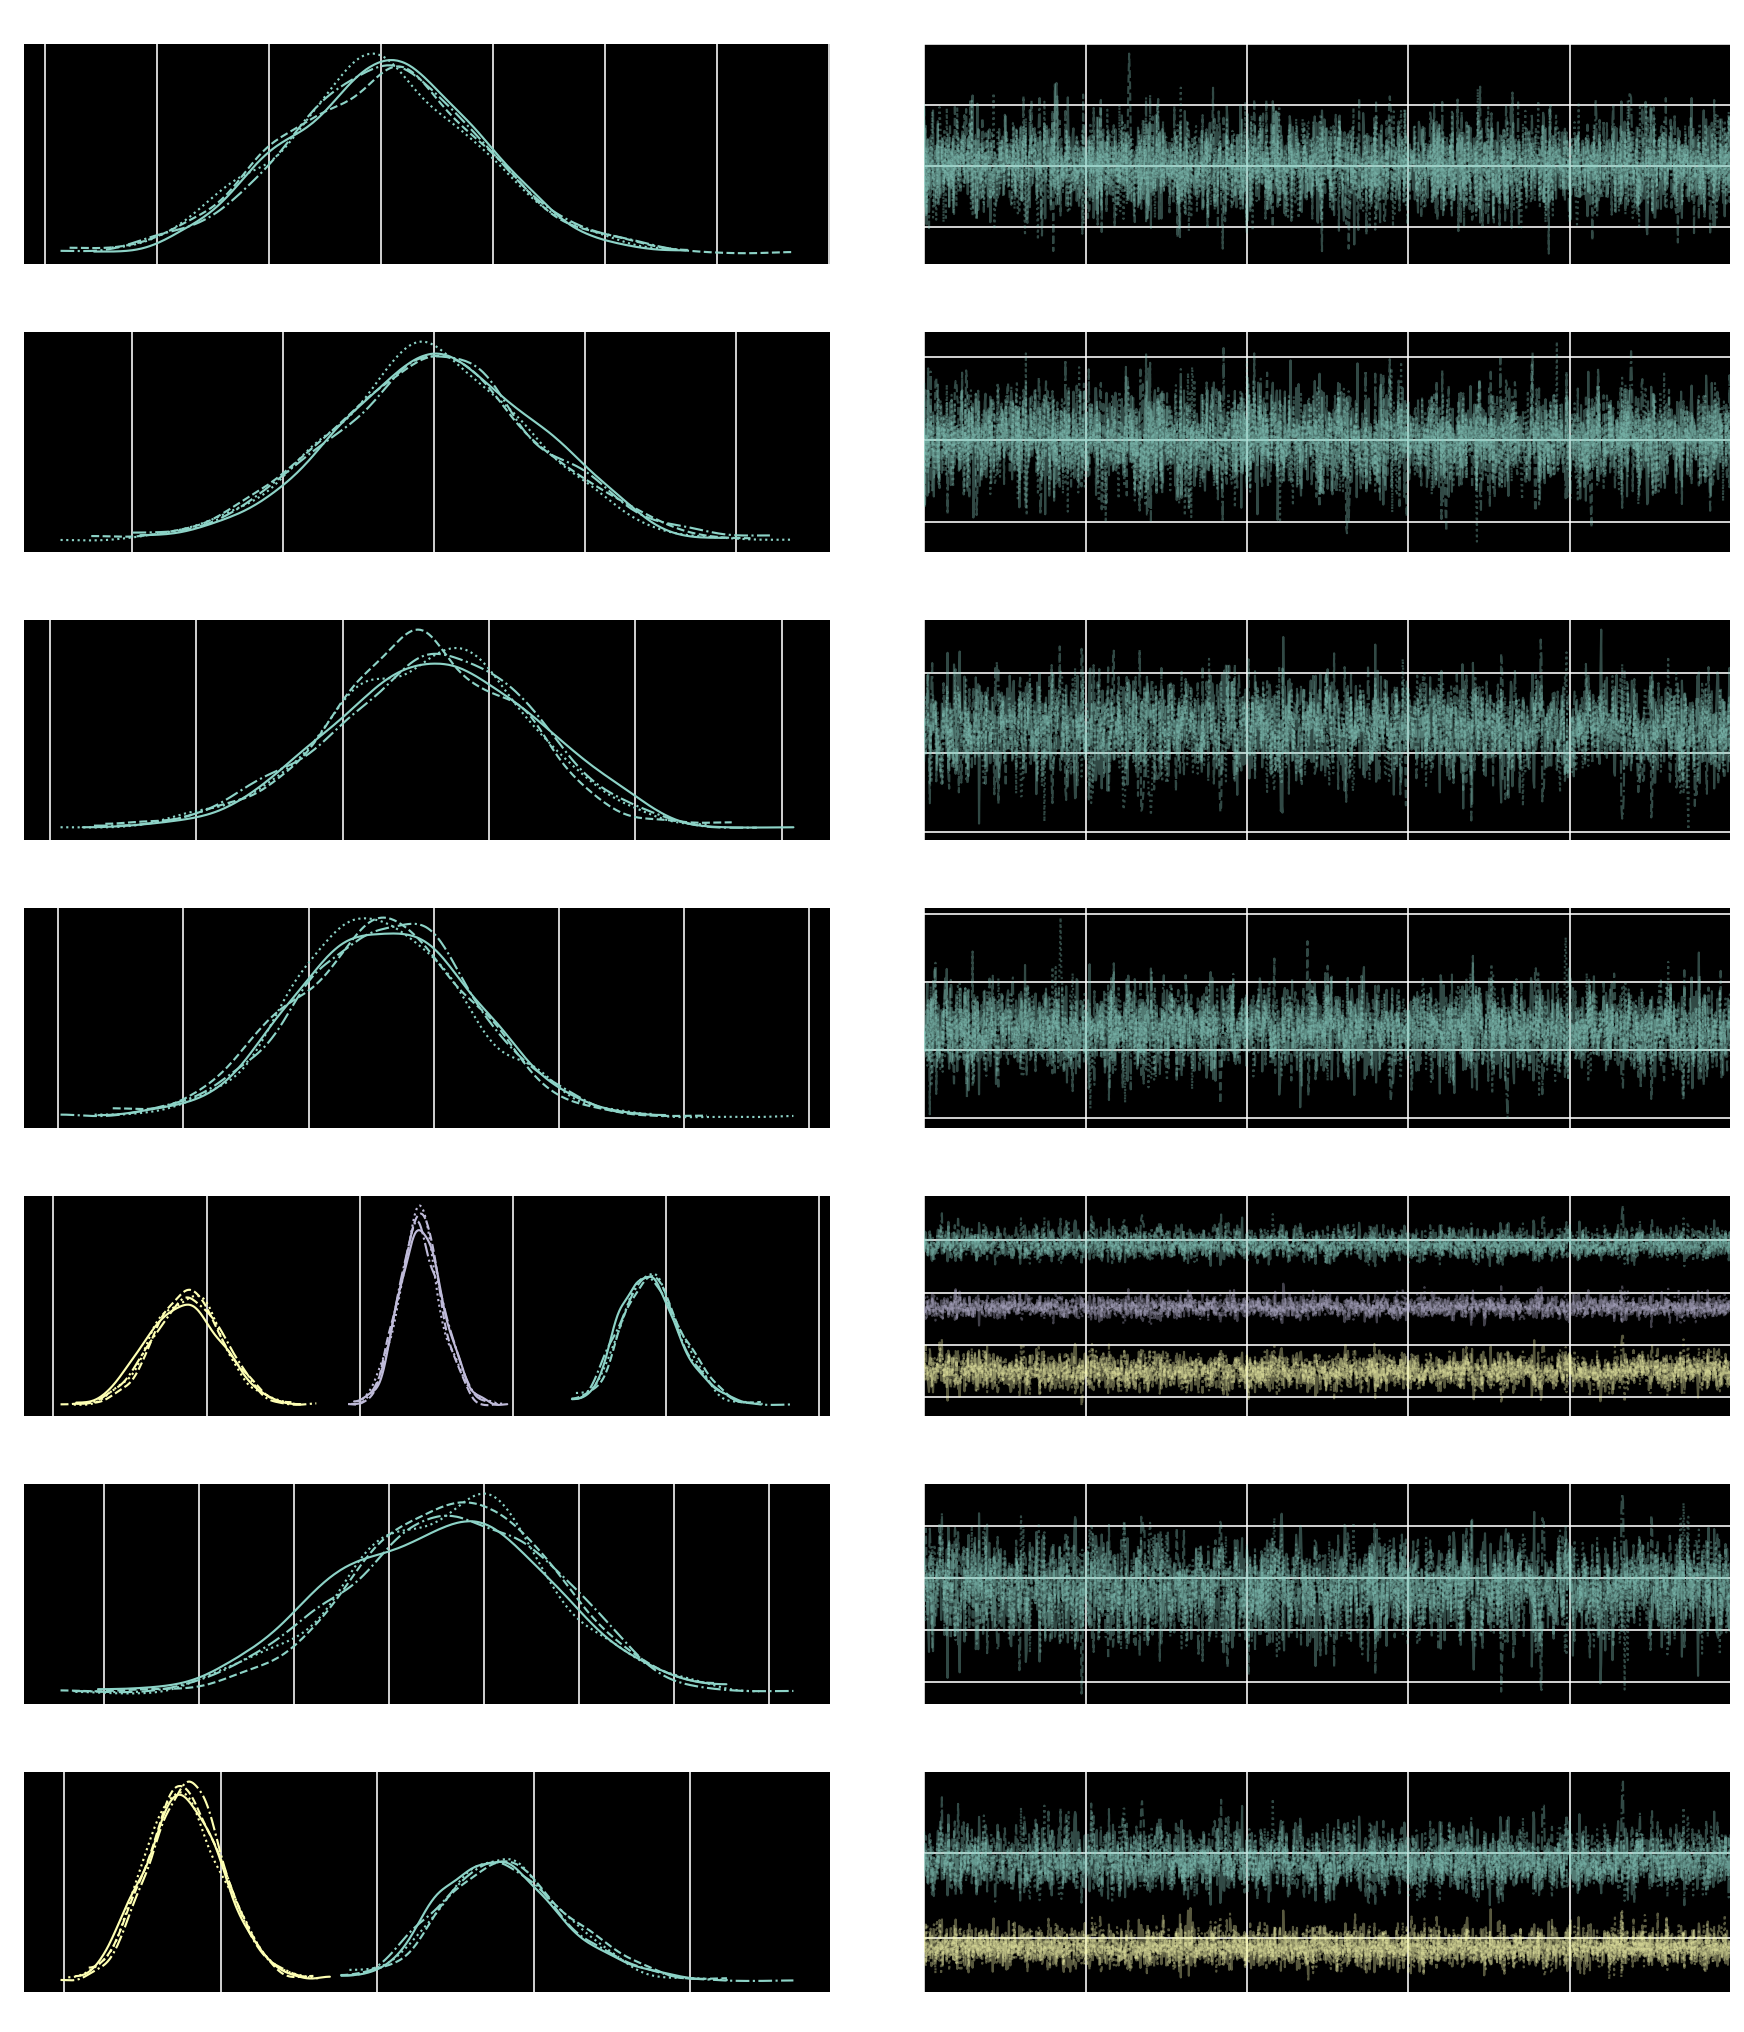

In [380]:
az.plot_trace(trace6, coords={'chol_corr_dim_0':1, 'chol_corr_dim_1':0});